In [2]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

## Helper Functions

In [15]:
def plot_confusion_matrix(top_left, top_right, bottom_left, bottom_right, horizontal_label, vertical_label):
    array = [[top_left, top_right],
            [bottom_left, bottom_right]]
    array_df = pd.DataFrame(array, index=["pass", "fail"], columns=["pass", "fail"])
    sn.set(font_scale=1.6)
    h = sn.heatmap(array_df, annot=True, fmt='d')
    h.set_xlabel(horizontal_label)
    h.set_ylabel(vertical_label)

def write_tests_to_investigate(df, file_name):
    with open(f'test_results/{file_name}', 'w') as f:
        for name, row in df.iterrows():
            print("\n\n-----------------------------------\n\n", file=f)
            out = row.test_stdout.strip() if row.test_stdout is not None else None
            err = row.test_stderr.strip() if row.test_stderr is not None else None
            print(f"name = {name}\ntest_status = {row.test_status}\ntest_time = {row.test_time}\ntest_timeout = {row.test_timeout}\n\ntest_stdout =\n{out}\n\n\ntest_stderr = \n{err}", file=f)
    print(f"Saved test outputs to: test_results/{file_name}")

## Load Data

In [4]:
vanilla_df = pd.read_json('test_results/vanilla_top1000tarball_repos.json', orient='index')
vanilla_df.index.name = 'name'

minnpm_df = pd.read_json('test_results/minnpm_top1000tarball_repos_with_esm.json', orient='index')
minnpm_df.index.name = 'name'

In [5]:
vanilla_df

,root,did_run_install,did_run_build,did_run_test,has_build_script,has_test_script,install_status,install_stdout,install_stderr,install_time,...,build_stdout,build_stderr,build_time,build_timeout,test_status,test_stdout,test_stderr,test_time,test_timeout,solve_type
name,,,,,,,,,,,,,,,,,,,,,
body-parser.tgz,top1000tarball_repos,True,False,True,False,True,0,"\nadded 423 packages, and audited 424 packages...",,15.884514,...,None,None,NaN,NaN,0.0,\n> body-parser@1.20.0 test\n> mocha --require...,,1.226599,0.0,vanilla
diff.tgz,top1000tarball_repos,True,False,True,False,True,0,"\nadded 1336 packages, and audited 1337 packag...",npm WARN deprecated urix@0.1.0: Please see htt...,34.113686,...,None,None,NaN,NaN,0.0,"\n> diff@5.0.0 test\n> grunt\n\nRunning ""clean...",Browserslist: caniuse-lite is outdated. Please...,8.122303,0.0,vanilla
leven.tgz,top1000tarball_repos,True,False,True,False,True,0,"\nadded 701 packages, and audited 702 packages...",npm WARN deprecated electron@0.4.1: The origin...,23.338215,...,None,None,NaN,NaN,0.0,\n> leven@4.0.0 test\n> xo && ava && tsd\n\n\n...,,9.559732,0.0,vanilla
is-bigint.tgz,top1000tarball_repos,True,False,True,False,True,0,"\nadded 310 packages, and audited 493 packages...",,10.376232,...,None,None,NaN,NaN,0.0,\n> is-bigint@1.0.4 pretest\n> npm run lint\n\...,,7.377957,0.0,vanilla
regex-not.tgz,top1000tarball_repos,True,False,True,False,True,0,"\nadded 183 packages, and audited 184 packages...",npm WARN deprecated source-map-url@0.4.1: See ...,4.654048,...,None,None,NaN,NaN,0.0,\n> regex-not@1.0.2 test\n> mocha\n\n\n\n reg...,,0.382288,0.0,vanilla
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
css-loader.tgz,top1000tarball_repos,True,True,True,True,True,0,"\nadded 1212 packages, and audited 1213 packag...",npm WARN deprecated source-map-resolve@0.6.0: ...,126.598913,...,\n> css-loader@6.7.1 prebuild\n> npm run clean...,,2.121869,0.0,0.0,\n> css-loader@6.7.1 pretest\n> npm run lint\n...,PASS test/runtime/getUrl.test.js\nPASS test/ru...,19.064244,0.0,vanilla
is-path-in-cwd.tgz,top1000tarball_repos,True,False,True,False,True,0,"\nadded 813 packages, and audited 814 packages...",npm WARN deprecated source-map-url@0.4.1: See ...,115.509984,...,None,None,NaN,NaN,0.0,\n> is-path-in-cwd@4.0.0 test\n> xo && ava && ...,,10.328571,0.0,vanilla
acorn-globals.tgz,top1000tarball_repos,True,False,True,False,True,0,"\nadded 16 packages, and audited 17 packages i...",,1.604646,...,None,None,NaN,NaN,0.0,\n> acorn-globals@6.0.0 test\n> node test\n\n ...,,0.406356,0.0,vanilla


## How many did we actually run tests on?

In [6]:
vanilla_ran = vanilla_df.did_run_test.sum()
minnpm_ran = minnpm_df.did_run_test.sum()
print(f"Vanilla ran {vanilla_ran} tests")
print(f"MinNPM ran {minnpm_ran} tests")

Vanilla ran 750 tests
MinNPM ran 736 tests


## How many tests passed (judged via exit code = 0)

In [7]:
vanilla_passed = (vanilla_df[vanilla_df.did_run_test].test_status == 0).sum()
minnpm_passed = (minnpm_df[minnpm_df.did_run_test].test_status == 0).sum()
print(f"Vanilla passed {vanilla_passed} tests ({vanilla_passed / vanilla_ran * 100}%)")
print(f"MinNPM passed {minnpm_passed} tests ({minnpm_passed / minnpm_ran * 100}%)")

Vanilla passed 613 tests (81.73333333333333%)
MinNPM passed 571 tests (77.58152173913044%)


## Comparing Passes / Fails with Vanilla and MinNPM

735 tests were ran by both Vanilla and MinNPM


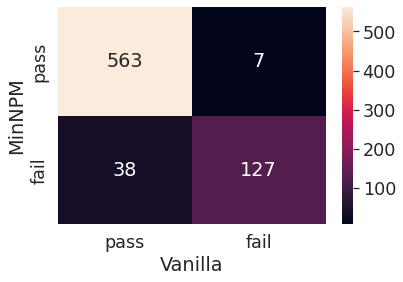

In [8]:
ran_by_both = vanilla_df.did_run_test & minnpm_df.did_run_test
ran_by_both_count = ran_by_both.sum()
print(f"{ran_by_both_count} tests were ran by both Vanilla and MinNPM")

vanilla_passes_minnpm_passes = ran_by_both & (vanilla_df.test_status == 0) & (minnpm_df.test_status == 0)
vanilla_fails_minnpm_passes = ran_by_both & (vanilla_df.test_status != 0) & (minnpm_df.test_status == 0)
vanilla_passes_minnpm_fails = ran_by_both & (vanilla_df.test_status == 0) & (minnpm_df.test_status != 0)
vanilla_fails_minnpm_fails = ran_by_both & (vanilla_df.test_status != 0) & (minnpm_df.test_status != 0)

plot_confusion_matrix(vanilla_passes_minnpm_passes.sum(), vanilla_fails_minnpm_passes.sum(), vanilla_passes_minnpm_fails.sum(), vanilla_fails_minnpm_fails.sum(), 'Vanilla', 'MinNPM')

## Tests that Passed with Vanilla and Failed with MinNPM

In [18]:
tests_to_investigate_df = minnpm_df[vanilla_passes_minnpm_fails][['test_status', 'test_stdout', 'test_stderr', 'test_time', 'test_timeout']]
write_tests_to_investigate(tests_to_investigate_df, 'tests_to_inspect.txt')
tests_to_investigate_df

Saved test outputs to: test_results/tests_to_inspect.txt


,test_status,test_stdout,test_stderr,test_time,test_timeout
name,,,,,
parse-json.tgz,1.0,\n> parse-json@6.0.2 test\n> xo && nyc ava\n\n,Error: Failed to load plugin 'unicorn' declare...,1.221200,0.0
strip-ansi.tgz,1.0,\n> strip-ansi@7.0.1 test\n> xo && ava && tsd\n\n,/tmp/tmp3h0u6hkg/package/node_modules/strip-an...,0.777600,0.0
aggregate-error.tgz,1.0,\n> aggregate-error@4.0.1 test\n> ava && tsd\n\n,/tmp/tmp0e54bzhs/package/node_modules/aggregat...,0.369292,0.0
eslint-plugin-import.tgz,66.0,\n> eslint-plugin-import@2.26.0 pretest\n> lin...,\nLinked 6 dependencies\n\nError while parsing...,39.380328,0.0
cli-cursor.tgz,1.0,\n> cli-cursor@4.0.0 test\n> xo && ava && tsd\n\n,/tmp/tmpqa3azyrf/package/node_modules/cli-curs...,5.137375,0.0
wrap-ansi.tgz,1.0,\n> wrap-ansi@8.0.1 test\n> xo && nyc ava\n\n,/tmp/tmp4rl5q0vq/package/node_modules/eslint-f...,0.809373,0.0
npm-run-path.tgz,1.0,\n> npm-run-path@5.1.0 test\n> xo && ava && ts...,/tmp/tmpf23znx63/package/node_modules/cross-sp...,0.823386,0.0
p-locate.tgz,1.0,\n> p-locate@6.0.0 test\n> xo && ava && tsd\n\n,/tmp/tmpr6f2aeey/package/node_modules/pkg-dir/...,0.968923,0.0
onetime.tgz,1.0,\n> onetime@6.0.0 test\n> xo && ava && tsd\n\n,/tmp/tmpazria0ps/package/node_modules/mem/dist...,4.306078,0.0


In [19]:
tests_to_investigate_df = vanilla_df[vanilla_fails_minnpm_passes][['test_status', 'test_stdout', 'test_stderr', 'test_time', 'test_timeout']]
write_tests_to_investigate(tests_to_investigate_df, 'tests_to_inspect2.txt')
tests_to_investigate_df

Saved test outputs to: test_results/tests_to_inspect2.txt


,test_status,test_stdout,test_stderr,test_time,test_timeout
name,,,,,
neo-async.tgz,1.0,\n> neo-async@2.6.2 test\n> istanbul cover ./n...,error\nlog\ntest\n============================...,35.753817,0.0
get-intrinsic.tgz,1.0,\n> get-intrinsic@1.1.2 pretest\n> npm run lin...,evalmd info it worked if it ends with ok\neval...,0.774891,0.0
array.prototype.flat.tgz,1.0,\n> array.prototype.flat@1.3.0 pretest\n> npm ...,evalmd info it worked if it ends with ok\neval...,1.657289,0.0
array-includes.tgz,1.0,\n> array-includes@3.1.5 pretest\n> npm run --...,evalmd info it worked if it ends with ok\neval...,0.791687,0.0
bl.tgz,1.0,\n> bl@5.0.0 test\n> npm run lint && node test...,node:internal/fs/utils:344\n throw err;\n ...,3.949296,0.0
call-bind.tgz,1.0,\n> call-bind@1.0.2 pretest\n> npm run lint\n\...,evalmd info it worked if it ends with ok\neval...,1.498611,0.0
mimic-response.tgz,1.0,\n> mimic-response@4.0.0 test\n> xo && ava && ...,,6.436579,0.0
